### 

### A SQL learning plataform, desguised as a detective game!
#### From: http://mystery.knightlab.com/ <br> https://github.com/NUKnightLab/sql-mysteries

Note: I wasn't able to use the .db provided at https://github.com/NUKnightLab/sql-mysteries within the Deepnote notebook (*if that's possible and you know how to do it please let me know, thanks!* <br> 
I understand that I could have imported a SQL library and ran the codes using Python, but I wanted to fully focus on writing SQL as I've recently learned. <br>
As a workaround I loaded de .db, wrote and ran the queries at https://sqliteonline.com/, and then pasted the queries here. <br>
If you'd like to walk through my reasoning, I believe you'll have to copy the queries from this notebook to a plataform of your choice. <br>
I apologize for the hassle, and thanks for being understandable <3

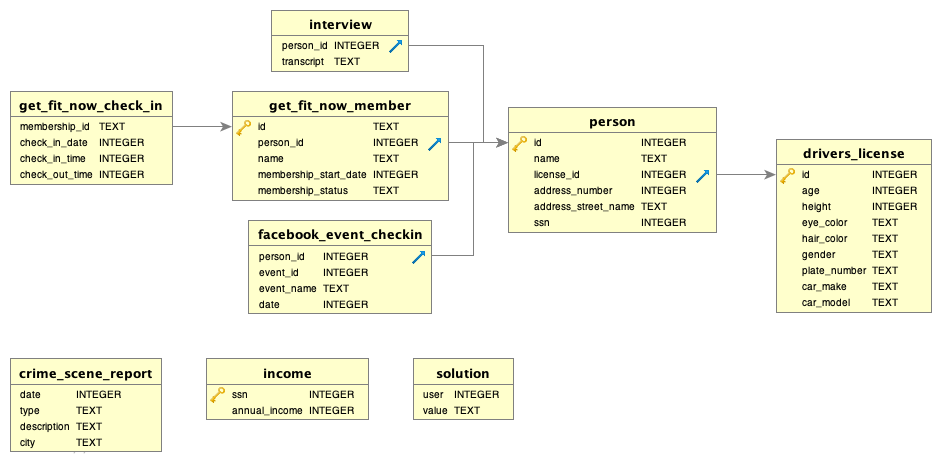

In [ ]:
# Schema

from PIL import Image

img = Image.open(r"/work/schema.png") 
img.show() 

#### A crime has taken place and the detective needs your help. The detective gave you the crime scene report, but you somehow lost it. You vaguely remember that the crime was a ​murder​ that occurred sometime on ​Jan.15, 2018​ and that it took place in ​SQL City​. Start by retrieving the corresponding crime scene report from the police department’s database.

Run this query to find the names of the tables in this database.
This command is specific to SQLite.

In [ ]:


df_1 = _deepnote_execute_sql("""SELECT name 
FROM sqlite_master
where type = 'table';

SELECT * 
FROM crime_scene_report
WHERE date = 20180115
	AND type = 'murder'
	AND city = 'SQL City';
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_1

#### Security footage shows that there were 2 witnesses. The first witness lives at the last house on "Northwestern Dr". The second witness, named Annabel, lives somewhere on "Franklin Ave".


### Witness #1 - Unknown

In [ ]:


df_2 = _deepnote_execute_sql("""SELECT *
FROM person
INNER JOIN interview
ON person.id = interview.person_id
WHERE address_street_name = 'Northwestern Dr'  -- joining with interview table to get the transcript in one go
ORDER BY address_number DESC
LIMIT 1;

""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_2

### Our&nbsp;witness'&nbsp;name&nbsp;is&nbsp;Morty&nbsp;Schapiro.

His transcript:
#### - *"I heard a gunshot and then saw a man run out. He had a "Get Fit Now Gym" bag. The membership number on the bag started with "48Z". Only gold members have those bags. The man got into a car with a plate that included "H42W".*

I'd say we focus first on the car, who's its owner and then go from there. The bag could be a distraction, though, since we can't know for sure if it was from the killer, the victim's or if it was stolen from someone else.

In [ ]:


df_4 = _deepnote_execute_sql("""SELECT *
from drivers_license
INNER JOIN person 
ON drivers_license.id = person.license_id  -- joining so we can get the person's name, adress and more right away!
WHERE plate_number LIKE '%H42W%'
AND gender = 'male';

""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_4

#### We got two leads! Jeremy Bowers and Tushar Chandra.

With the following query we can find out which events they attended to:

In [ ]:


df_5 = _deepnote_execute_sql("""SELECT *
FROM facebook_event_checkin
INNER JOIN person 
ON facebook_event_checkin.person_id = person.id
WHERE person.name IN ('Jeremy Bowers', 'Tushar Chandra');
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_5

Jeremy Bowers attended both *The Funky Grooves Tour* and *SQL Symphony Concert*, while Tushar none.
Only the first event checks with the murder date, though. 

So we ask, who else was at *The Funky Grooves*?

In [ ]:


df_6 = _deepnote_execute_sql("""SELECT *
FROM facebook_event_checkin
INNER JOIN person
ON facebook_event_checkin.person_id = person.id
WHERE event_name LIKE '%Funky%';
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_6

#### Our two witnesses, Morty Sharpiro and Annabel Miller!

But before we get antsy, let's be on the safe side and gather whatever useful information we can on the gym bag '48Z'.

In [ ]:


df_7 = _deepnote_execute_sql("""SELECT * 
FROM get_fit_now_member
INNER JOIN get_fit_now_check_in AS chk
ON get_fit_now_member.id = chk.membership_id
WHERE membership_status = 'gold'
AND name LIKE '%Bowers%';
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_7

#### Turns out the bag WAS from Jeremy Bowers, the one who ran away with it from the crime scene!

For our investigation's sake let's keep a record of his last appearance at the gym: Jan. 9th 2018, check-in: 15:00, check-out: 17:30.<br>
We might be able to cross this information in the future, if somehow we find out that Mr. Bowers was just a pawn all along.

### Witness #2 - Annabel Miller

In [ ]:


df_9 = _deepnote_execute_sql("""SELECT transcript 
FROM person
INNER JOIN interview
ON person.id = interview.person_id
WHERE name = 'Annabel Miller';

""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_9

Annabel's transcript:
#### - *"I saw the murder happen, and I recognized the killer from my gym when I was working out last week on January the 9th."*
Check-in and check-out hours. Who was there with Annabel?


In [ ]:


df_8 = _deepnote_execute_sql("""-- By running the query once we know the witness was at the gym between 16:00-17:00, 
-- which can be used in our next query filter

SELECT *
FROM get_fit_now_check_in as gym
INNER JOIN get_fit_now_member as member
ON gym.membership_id = member.id
WHERE check_in_date = '20180109'
AND check_in_time BETWEEN 1400 AND 1700;  -- filtering from 14:00, in case the killer arrived earlier than the witness

""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_8

#### Two potential suspects. Joe Germuska and... guess who? Jeremy Bowers
Remember that the first witness (Morty Schapiro) said that the killer got in a car after leaving the gym?<br>
With that in mind let's see if this new guy Joe even owns a ride...

In [ ]:


df_9 = _deepnote_execute_sql("""SELECT *
from drivers_license
INNER JOIN person 
ON drivers_license.id = person.license_id
WHERE plate_number LIKE '%H42W%'
OR name LIKE '%muska'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_9

#### Nope... all roads leads to Jeremy Bowers.<br> But before turning him in, let´s see if we can find any more clues.

What about his financial situation? Could this have been a trigger? <br>
With the query above we have access to his social security number (ssn) and we check out his yearly revenue.

In [ ]:


df_10 = _deepnote_execute_sql("""SELECT *
FROM income
WHERE ssn = 871539279
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_10

He makes 10.5k/year and sometimes that's not enough for some people. It's possible he could've been a gun for hire.<br>
Since he was spotted at the crime scene, has the police collected his transcript at any point?



In [ ]:


df_11 = _deepnote_execute_sql("""SELECT transcript
FROM interview
INNER JOIN person
ON interview.person_id = person.id
WHERE name = 'Jeremy Bowers'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_11

#### - *I was hired by a woman with a lot of money. I don't know her name but I know she's around 5'5" (65") or 5'7" (67"). She has red hair and she drives a Tesla Model S. I know that she attended the SQL Symphony Concert 3 times in December 2017.*


We got him, but he has already confessed! That means our work is not done yet.<br>
At least we got a bunch of information from his transcript - let's put them to good use.

In [ ]:


df_12 = _deepnote_execute_sql("""SELECT *
FROM drivers_license
INNER JOIN person
ON drivers_license.id = person.license_id
WHERE gender = 'female'
AND hair_color = 'red'
AND height BETWEEN 65 AND 67
AND car_make = 'Tesla'
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_12

#### Red Korb, Regina George and Miranda Priestly matched the killer's description.

Last step: who attended *SQL Symphony Concert* three times in Dec. 2017?

In [ ]:


df_13 = _deepnote_execute_sql("""SELECT *
from facebook_event_checkin as fb
INNER JOIN person
ON fb.person_id = person.id
INNER JOIN income   -- extra join to find out the yearly income
ON person.ssn = income.ssn    
WHERE event_name LIKE '%Symphony%'
AND date LIKE '2017%'
AND name in ('Red Korb', 'Regina George', 'Miranda Priestly')
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
df_13

## **The Mastermind:** Miranda Priestly!
Attended the concert on Dec. 6, 12 and 29 of 2017.<br>
Also, Jeremy was right when he said this lady had a lot of money - she makes 310k/year!

*"Congrats, you found the brains behind the murder! Everyone in SQL City hails you as the greatest SQL detective of all time. Time to break out the champagne!*


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e92ccdea-1118-4ae1-aa97-eb7af480f736' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>